# Native gates on IonQ

In this notebook, we will dive into the details of IonQ's native gates and their functionalities, enabling us to realize direct control over the quantum operations on the computer without compiler optimizations or error mitigation. We will discuss the key native gates available on IonQ, their mathematical representations, and how they can be used for applications such as the quantum Fourier transform (QFT). 


IonQ's native gateset includes the GPi, GPi2, and arbitrary angle MS gate. These gates are physically implemented on IonQ hardware by utilizing resonant lasers to address ions through stimulated Raman transitions. The three gates provide a universal gate set for quantum computation. This means any quantum circuit can be realized with only these elementary operations. 

The notebook is organized into the following sections:


## Table of Contents
- Single-qubit gates
    - GPi gate: $X, Y$ gates
    - GPi2 gate: $R_X(\pi/2), R_Y(\pi/2)$ gates
    - General gate decompositions
    - Common single-qubit gates: $H$, $S$, $T$.
    - Writing native IonQ circuits in Braket 
- Two-qubit gates: Arbitrary angle Mølmer-Sørenson gate
  - Mapping CNot into $XX$
  - Mapping controlled roots of Pauli gates into $XX$ gates
- Quantum Fourier transform with native gates

## Single-qubit native gates

### GPi gate

The GPi gate is a fundamental single-qubit gate used in IonQ's trapped-ion quantum computing systems. It performs a rotation of $\pi$ radians (180 degrees) on the Bloch sphere. What makes the GPi gate unique is its ability to rotate along any axis in the $x-y$ plane of the Bloch sphere. By adjusting the parameter $\phi$, the gate can be mapped to different azimuthal angles. 

In [1]:
from sympy import I, Matrix, exp, pi, sqrt, symbols

phi = symbols("phi")

gpi = Matrix([[0, exp(-I * phi)], [exp(I * phi), 0]])
GPi = lambda x: gpi.subs({"phi": x})

print("The GPi gate is defined as:")
GPi(phi)

The GPi gate is defined as:


Matrix([
[         0, exp(-I*phi)],
[exp(I*phi),           0]])

For $\phi=0$, the GPi gate is equivalent to the Pauli $X$-gate

In [2]:
x = GPi(0)
x

Matrix([
[0, 1],
[1, 0]])

For $\phi=\pi/2$, the GPi gate is the Pauli $Y$ gate

In [3]:
y = GPi(pi / 2)
y

Matrix([
[0, -I],
[I,  0]])

In summary, the GPi gate offers the capability to provide Pauli $X$ and $Y$ rotations, as well as rotations about any azimuthal angle on the Bloch sphere.

### GPi2 gate

The GPi2 gate performs a rotation of $\pi/2$ radians (90 degrees) on the Bloch sphere. Similar to the GPi gate, the GPi2 gate provides flexibility by allowing rotations along any longitudinal axis of the Bloch sphere. It can be considered as an $R_X(\pi/2)$ or $R_Y(\pi/2)$ gate, depending on the parameter $\phi$. 

In [4]:
gpi2 = 1 / sqrt(2) * Matrix([[1, -I * exp(-I * phi)], [-I * exp(I * phi), 1]])
GPi2 = lambda x: gpi2.subs({"phi": x})

print("The GPi2 gate is defined as:")
GPi2(phi)

The GPi2 gate is defined as:


Matrix([
[              sqrt(2)/2, -sqrt(2)*I*exp(-I*phi)/2],
[-sqrt(2)*I*exp(I*phi)/2,                sqrt(2)/2]])

The $R_X(\pi/2)$ rotation gate is realized by setting $\phi=0$

In [5]:
rx_pi2 = GPi2(0)
rx_pi2

Matrix([
[   sqrt(2)/2, -sqrt(2)*I/2],
[-sqrt(2)*I/2,    sqrt(2)/2]])

So the GPI2 can realize the square root of the $X$ gate, $\text{GPi}(0) = R_X(\pi/2)=e^{-i \pi/4}\sqrt{X}=e^{-i \pi/4}V$ but to a phase. In Braket, this is the $V$ gate. 


Likewise, the The $R_Y(\pi/2)$ rotation gate is realized by setting $\phi=\pi/2$

In [6]:
ry_pi2 = GPi2(pi / 2)
ry_pi2

Matrix([
[sqrt(2)/2, -sqrt(2)/2],
[sqrt(2)/2,  sqrt(2)/2]])

In summary, the GPi2 provides a way to use a native $V$ gate on IonQ as well as $\pi/2$ Pauli-$Y$ rotations.

### General single-qubit decompositions

Any single-qubit gate can be decomposed into a sequence of rotations around the three axes of the Bloch sphere. Each rotation is parameterized by one of the Euler angles. The $\alpha$ angle corresponds to the rotation around the $Z$ axis, the $\beta$ angle corresponds to the rotation around the $X$ axis, and the $\gamma$ angle corresponds to the rotation around the $Z$ axis again. This is known as the ZXZ decomposition. 

$$\begin{equation}
R(\alpha,\beta,\gamma) = \operatorname{Rz}(\alpha) \operatorname{Rx}(\beta) \operatorname{Rz}(\gamma) 
\end{equation}$$

Instead of ZXZ, the IonQ native gates provide a basis for a similar decomposition. The mapping from the typical ZXZ to native gates is:
$$\begin{equation}
R(\alpha,\beta,\gamma) = -i \,
\text{GPi2}\left(\alpha-\frac{\pi}{2}\right) \,\text{GPi}\left(\frac{\alpha-\gamma-\beta-\pi}{2}\right) \,\text{GPi2}\left(\frac{3\pi}{2}-\gamma\right)
\end{equation}$$

In [7]:
from sympy import I, Matrix, cos, exp, expand, pi, simplify, sin, symbols, trigsimp

alpha, beta, gamma = symbols("alpha, beta, gamma")

RX = lambda alpha: Matrix(
    [[cos(alpha / 2), -I * sin(alpha / 2)], [-I * sin(alpha / 2), cos(alpha / 2)]]
)
RZ = lambda beta: Matrix([[exp(-I * beta / 2), 0], [0, exp(I * beta / 2)]])

zxz = simplify(RZ(alpha) * RX(beta) * RZ(gamma), full=True)
zxz

Matrix([
[  exp(-I*(alpha + gamma)/2)*cos(beta/2), -I*exp(-I*(alpha - gamma)/2)*sin(beta/2)],
[-I*exp(I*(alpha - gamma)/2)*sin(beta/2),     exp(I*(alpha + gamma)/2)*cos(beta/2)]])

In [8]:
# with some help, sympy can simplify this expression
general_rotation = (
    GPi2(alpha - pi / 2) * GPi((alpha - beta - gamma + pi) / 2) * GPi2(3 * pi / 2 - gamma)
)
general_rotation = simplify(
    exp(-I * alpha / 2) * exp(I * gamma / 2) * general_rotation
)  # bottom sin
general_rotation = simplify(exp(I * alpha) * general_rotation)  # cos
general_rotation = simplify(exp(-I * gamma) * general_rotation)  # top sin
general_rotation = simplify(exp(-I * alpha) * general_rotation)  # bottom cos
general_rotation = simplify(
    exp(I * (alpha + gamma) / 2) * general_rotation
)  # undo the phase factors
general_rotation

Matrix([
[I*exp(-I*(alpha + gamma)/2)*cos(beta/2),  exp(I*(-alpha + gamma)/2)*sin(beta/2)],
[   exp(I*(alpha - gamma)/2)*sin(beta/2), I*exp(I*(alpha + gamma)/2)*cos(beta/2)]])

Therefore, the combination of GPi and GPi2 gates gives the same effect as ZXZ up to a phase factor of $-i$. This decomposition allows any arbitrary single-qubit gate to run as a combination of native gates on IonQ. 

### Common single-qubit gates

For example, the Hadamard gate is usually decomposed as $H=X\,R_Y(\pi/2)$. This can be implemented as follows:

In [9]:
# H = X * sqrt(Y)
hadamard = GPi(0) * GPi2(pi / 2)
hadamard

Matrix([
[sqrt(2)/2,  sqrt(2)/2],
[sqrt(2)/2, -sqrt(2)/2]])

We can use the general single-qubit rotation decomposition to contruct more complex gates such as $R_X, R_Y, R_Z, S, T$. Below we list the gates and their decompositions. 

In [10]:
theta = symbols("theta")

ID = GPi(0) * GPi(0)
X = GPi(0)
Y = GPi(pi / 2)
Z = 1j * GPi(pi / 2) * GPi(pi)

RX = I * GPi2(pi / 2) * GPi(theta / 2 + pi / 2) * GPi2(pi / 2)
RY = I * GPi2(pi) * GPi(theta / 2 + pi) * GPi2(pi)
RZ = GPi(theta / 2) * GPi(0)

H = GPi(0) * GPi2(pi / 2)
T = -I * exp(I * pi / 8) * GPi2(-3 * pi / 8) * GPi(pi / 2) * GPi2(11 * pi / 8)
S = -I * exp(I * pi / 4) * GPi2(-pi / 4) * GPi(pi / 2) * GPi2(5 * pi / 4)

### Native gate circuits on Braket 

In this section we should how to write native gate circuits in Amazon Braket SDK. 

Rather than remembering all the single-qubit decompositions, we can override the support gates ($I$, $X$, $H$, etc) to use their native gate decomposition. To prevent chanign the `Circuit` class in Braket, we create a new subclass of `Circuit` called `IonQNativeCircuit`. This give a way to modify the gate definitions without adjusting the circuit class. 

Below, we provide a code snippet that creates the native circuit class with the gate definitions from the previous section. 

In [11]:
import numpy as np
from braket.circuits import Circuit


class IonQNativeCircuit(Circuit):
    pi = np.pi

    # universal single-qubit rotation decomposition
    def unitary(self, qubit, a, b, c):
        return self.gpi2(qubit, a).gpi(qubit, b).gpi2(qubit, c)

    def i(self, qubit):
        return self.gpi(qubit, 0).gpi(qubit, 0)

    def x(self, qubit):
        return self.gpi(qubit, 0)

    def y(self, qubit):
        return self.gpi(qubit, pi / 2)

    def z(self, qubit):
        return self.gpi(qubit, pi).gpi(qubit, pi / 2)

    def h(self, qubit):
        return self.gpi2(qubit, pi / 2).gpi(qubit, 0)

    def t(self, qubit):
        return self.unitary(qubit, 11 * pi / 8, pi / 2, -3 * pi / 8)

    def s(self, qubit):
        return self.unitary(qubit, 5 * pi / 4, pi / 2, -pi / 4)

    def rx(self, qubit, theta):
        return self.unitary(qubit, pi / 2, theta / 2 + pi / 2, pi / 2)

    def ry(self, qubit, theta):
        return self.unitary(qubit, pi, theta / 2 + pi, pi)

    def rz(self, qubit, theta):
        return self.gpi(qubit, 0).gpi(qubit, theta / 2)

    # add friendly printing to unitary printing
    def to_unitary(self):
        return np.round(super().to_unitary(), 5)

We can create native circuits with the usual Braket syntax:

In [12]:
print(IonQNativeCircuit().h(0).rz(0, pi / 2))

T  : |    0     |  1   |  2   |    3    |
                                         
q0 : -GPi2(pi/2)-GPi(0)-GPi(0)-GPi(pi/4)-

T  : |    0     |  1   |  2   |    3    |


Notice how each gate is expanded into the native gate set. 

We can double check that the unitaries are the same for both circuits




In [13]:
unitary = Circuit().h(0).rz(0, 0.4).to_unitary()
unitary_native = IonQNativeCircuit().h(0).rz(0, 0.4).to_unitary()

np.isclose(unitary, unitary_native)

array([[ True,  True],
       [ True,  True]])

In summary, this section provided details about the native gate set on IonQ. 
It gave an overview of how to construct common single-qubit gates using the GPi and GPi2 gates. 
Lastly, the code snippet demonstrates how Braket SDK can construct native gate circuits. 

## Two-qubit entangling gates

### Arbitrary angle Mølmer-Sørenson gate 

The native two-qubit entangling gate on IonQ is the arbitrary angle Mølmer-Sørenson (MS) gate. It realizes an XX gate, this is a simultaneous, entangling $\pi/2$ rotation on both qubits, however with other angles, both XY and YY are possible. 

The arbitrary angle MS gate is defined as follows:

In [14]:
from sympy import I, Matrix, cos, exp, pi, sin, symbols
from sympy.interactive.printing import init_printing
from sympy.matrices import Matrix

init_printing(use_unicode=False, wrap_line=False)

theta, phi_0, phi_1 = symbols("theta phi_0 phi_1")

aams_matrix = Matrix(
    [
        [cos(theta / 2), 0, 0, -I * exp(-I * (phi_0 + phi_1)) * sin(theta / 2)],
        [0, cos(theta / 2), -I * exp(-I * (phi_0 - phi_1)) * sin(theta / 2), 0],
        [0, -I * exp(I * (phi_0 - phi_1)) * sin(theta / 2), cos(theta / 2), 0],
        [-I * exp(I * (phi_0 + phi_1)) * sin(theta / 2), 0, 0, cos(theta / 2)],
    ]
)
print("The arbitrary angle MS gate is defined as:")
aams_matrix

The arbitrary angle MS gate is defined as:


[              /theta\                                                                                      -I*(phi_0 + phi_1)    /theta\]
[           cos|-----|                            0                                  0                  -I*e                  *sin|-----|]
[              \  2  /                                                                                                            \  2  /]
[                                                                                                                                        ]
[                                                /theta\                 -I*(phi_0 - phi_1)    /theta\                                   ]
[               0                             cos|-----|             -I*e                  *sin|-----|                  0                ]
[                                                \  2  /                                       \  2  /                                   ]
[                          

If optional third angle $\theta$ is not provided, then the default value is $\theta=\pi/2$ which is the fully entangling MS gate:

In [15]:
print("The default MS gate is defined as:")

ms = aams_matrix.subs({"theta": pi / 2})
ms

The default MS gate is defined as:


[             ___                                                                              ___    -I*(phi_0 + phi_1) ]
[           \/ 2                                                                            -\/ 2 *I*e                   ]
[           -----                           0                              0                -----------------------------]
[             2                                                                                           2              ]
[                                                                                                                        ]
[                                           ___                 ___    -I*(phi_0 - phi_1)                                ]
[                                         \/ 2               -\/ 2 *I*e                                                  ]
[             0                           -----              -----------------------------                0              ]
[               

The more familiar $XX(\theta)$ gate is realized by setting the first two MS angles to zero.

In [16]:
print("The XX(theta) gate is defined as:")

xx = aams_matrix.subs({"phi_0": 0, "phi_1": 0})
xx

The XX(theta) gate is defined as:


[    /theta\                                        /theta\]
[ cos|-----|          0              0        -I*sin|-----|]
[    \  2  /                                        \  2  /]
[                                                          ]
[                   /theta\          /theta\               ]
[      0         cos|-----|    -I*sin|-----|        0      ]
[                   \  2  /          \  2  /               ]
[                                                          ]
[                     /theta\      /theta\                 ]
[      0        -I*sin|-----|   cos|-----|          0      ]
[                     \  2  /      \  2  /                 ]
[                                                          ]
[      /theta\                                    /theta\  ]
[-I*sin|-----|        0              0         cos|-----|  ]
[      \  2  /                                    \  2  /  ]

The YY gate is achieved by setting $\phi_0=\phi_1 = \pi/2$

In [17]:
print("The YY(theta) gate is defined as:")

yy = aams_matrix.subs({"phi_0": pi / 2, "phi_1": pi / 2})
yy

The YY(theta) gate is defined as:


[    /theta\                                      /theta\]
[ cos|-----|         0              0        I*sin|-----|]
[    \  2  /                                      \  2  /]
[                                                        ]
[                  /theta\          /theta\              ]
[     0         cos|-----|    -I*sin|-----|       0      ]
[                  \  2  /          \  2  /              ]
[                                                        ]
[                    /theta\      /theta\                ]
[     0        -I*sin|-----|   cos|-----|         0      ]
[                    \  2  /      \  2  /                ]
[                                                        ]
[     /theta\                                    /theta\ ]
[I*sin|-----|        0              0         cos|-----| ]
[     \  2  /                                    \  2  / ]

In the next section we breakdown how this MS gate can be used for CNot gates. 

### CNot gate decomposition

The CNot gate is the most commonly used two-qubit entangling gate. As such, its important to recognize how to map it to the native MS gate of IonQ. By decomposing the CNot gate into a combination of single-qubit rotations and the MS gate, we can express it in terms of IonQ's native gate set.

In the figure below, we show the decomposition from [1]. 

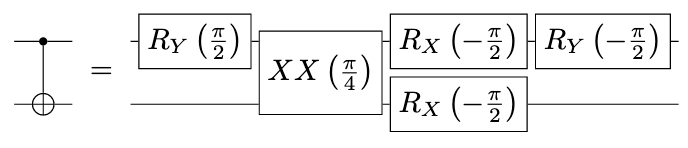



[1] Maslov, Dmitri. “Basic Circuit Compilation Techniques for an Ion-Trap Quantum Machine.” New Journal of Physics 19, no. 2 (February 2017): 023035. https://doi.org/10.1088/1367-2630/aa5e47.

[2] "Getting started with Native Gates." https://ionq.com/docs/getting-started-with-native-gates



In [18]:
from braket.circuits import Circuit

circ = Circuit().cnot(0, 1)

print("The CNot circuit is:")
print(circ)

print("The CNot unitary :")
Matrix(circ.to_unitary())

The CNot circuit is:
T  : |0|
        
q0 : -C-
      | 
q1 : -X-

T  : |0|
The CNot unitary :


[1.0   0    0    0 ]
[                  ]
[ 0   1.0   0    0 ]
[                  ]
[ 0    0    0   1.0]
[                  ]
[ 0    0   1.0   0 ]

In [19]:
def cnot_decomposition(qubit0, qubit1):
    circ = Circuit()
    circ.ry(qubit0, pi / 2)
    circ.ms(qubit0, qubit1, 0, 0)
    circ.rx(qubit0, -pi / 2).rx(qubit1, -pi / 2)
    circ.ry(qubit0, -pi / 2)
    return circ


print(cnot_decomposition(0, 1))

T  : |   0    |      1       |    2    |    3    |
                                                  
q0 : -Ry(pi/2)-MS(0, 0, 1.57)-Rx(-pi/2)-Ry(-pi/2)-
               |                                  
q1 : ----------MS(0, 0, 1.57)-Rx(-pi/2)-----------

T  : |   0    |      1       |    2    |    3    |


Now checking the unitary we have

In [20]:
matrix = cnot_decomposition(0, 1).to_unitary()
global_phase = np.exp(-1j * np.pi / 4)

matrix = np.round(global_phase * matrix, 5)
Matrix(matrix)

[1.0   0    0    0 ]
[                  ]
[ 0   1.0   0    0 ]
[                  ]
[ 0    0    0   1.0]
[                  ]
[ 0    0   1.0   0 ]

which exactly matches the expected CNot unitary up to the phase $e^{-i\alpha\pi/4}$.

### Controlled-roots of Pauli gates

The arbitrary third angle in the MS gate allows more flexibility than the CNot gate. By adjusting the angle, it controls the amount of strength of the gate.

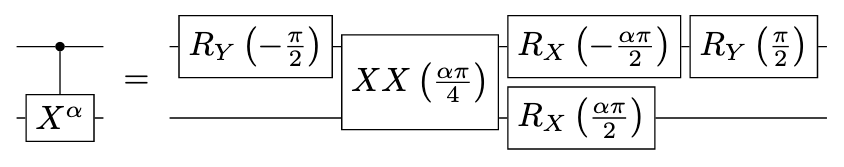



The arbitrary angle allows fraction powers of Pauli gates, for example the controlled-$X^{1/2}$ gate. 

In the following code, we check the unitary matrix for the controlled-$X^{1/2}$ gate against the MS decomposition to verify they are equivalent up to a global phase. 

In [21]:
from braket.circuits import Circuit

alpha = 0.5

circ = Circuit().x(1, control=0, power=alpha)
print(circ)

Matrix(np.round(circ.to_unitary(), 5))

T  : |   0   |
              
q0 : -C-------
      |       
q1 : -(X^0.5)-

T  : |   0   |


[1.0   0        0            0     ]
[                                  ]
[ 0   1.0       0            0     ]
[                                  ]
[ 0    0   0.5 + 0.5*I  0.5 - 0.5*I]
[                                  ]
[ 0    0   0.5 - 0.5*I  0.5 + 0.5*I]

In [22]:
def controlled_root_cnot_decomposition(qubit0, qubit1, alpha):
    circ = Circuit()
    circ.ry(qubit0, -np.pi / 2)
    circ.ms(qubit0, qubit1, 0, 0, alpha * np.pi / 2)
    circ.rx(qubit0, -alpha * np.pi / 2).rx(1, alpha * np.pi / 2)
    circ.ry(qubit0, np.pi / 2)
    return circ


matrix = controlled_root_cnot_decomposition(0, 1, alpha).to_unitary()
global_phase = np.exp(1j * np.pi * alpha / 4)

matrix = np.round(global_phase * matrix, 4)
Matrix(matrix)

[1.0   0        0            0     ]
[                                  ]
[ 0   1.0       0            0     ]
[                                  ]
[ 0    0   0.5 + 0.5*I  0.5 - 0.5*I]
[                                  ]
[ 0    0   0.5 - 0.5*I  0.5 + 0.5*I]

We see that the two unitaries are equivalent up to the phase $e^{i\alpha\pi/4}$. 

## Quantum Fourier transform with native gates

One application of native arbitrary angle MS gates is to the quantum Fourier transform (QFT) circuit. The QFT circuit involves a sequence of single-qubit rotations and controlled-phase operations. Note that the usual layer of SWAP gates at the end of the circuit can be dropped since then the re-ordering can be done classically.

In [23]:
import math

from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator

In [24]:
def cphaseshift(qubit0, qubit1, theta):
    qc = IonQNativeCircuit()
    qc.h(qubit1)
    qc.ry(qubit0, -pi / 2)
    qc.ms(qubit0, qubit1, 0, 0, theta / 2)
    qc.rx(qubit0, -theta / 2)
    qc.rx(qubit1, theta / 2)
    qc.ry(qubit0, pi / 2)
    qc.h(qubit1)
    return qc


IonQNativeCircuit.register_subroutine(cphaseshift)

In [25]:
Matrix(IonQNativeCircuit().cphaseshift(0, 1, pi / 3).to_unitary())

[0.96593 - 0.25882*I           0                    0                    0         ]
[                                                                                  ]
[         0           0.96593 - 0.25882*I           0                    0         ]
[                                                                                  ]
[         0                    0           0.96593 - 0.25882*I           0         ]
[                                                                                  ]
[         0                    0                    0           0.70711 + 0.70711*I]

In [26]:
m = IonQNativeCircuit().cphaseshift(0, 1, pi / 3).to_unitary()
Matrix(np.round(m * np.exp(1j * np.pi / 4 / 3), 5))

[1.0   0    0          0       ]
[                              ]
[ 0   1.0   0          0       ]
[                              ]
[ 0    0   1.0         0       ]
[                              ]
[ 0    0    0   0.5 + 0.86603*I]

In [27]:
def qft_no_swap(qubits):
    # The final SWAP layers are omitted in favor of classical post-processing
    qft_circ = IonQNativeCircuit()
    num_qubits = len(qubits)
    for k in range(num_qubits):
        qft_circ.h(qubits[k])
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1, num_qubits - k):
            angle = 2 * math.pi / (2 ** (j + 1))
            qft_circ.cphaseshift(qubits[k + j], qubits[k], angle)
    return qft_circ

In [28]:
num_qubits = 3
device = LocalSimulator()
qubits = range(num_qubits)

In [29]:
qft_circ = Circuit().h(0).add_circuit(qft_no_swap(qubits))
qft_circ.state_vector()
qft_circ.probability();

In [30]:
# Classical post-processing to replace SWAP gates in the QFT
def swap_classical_bitstrings(num_qubits):
    qubits_to_swap = [[qubits[i], qubits[-i - 1]] for i in range(math.floor(num_qubits / 2))]
    print(qubits_to_swap)

    swapped_bitstring_keys = []
    for pair in qubits_to_swap:
        for i in range(2**num_qubits):
            format_bitstring = "{0:0" + str(num_qubits) + "b}"
            bitstring_key = format_bitstring.format(i)
            tmp = bitstring_key[pair[1]]
            tmp2 = bitstring_key[pair[0]]
            swapped_bitstring = "".join(
                tmp if idx == pair[0] else tmp2 if idx == pair[1] else val
                for idx, val in enumerate(reversed(bitstring_key))
            )
            if swapped_bitstring not in swapped_bitstring_keys:
                swapped_bitstring_keys.append(swapped_bitstring)

    reindex = np.argsort(swapped_bitstring_keys)
    return swapped_bitstring_keys, reindex


swapped_bitstring_keys, reindex = swap_classical_bitstrings(num_qubits)

[[0, 2]]


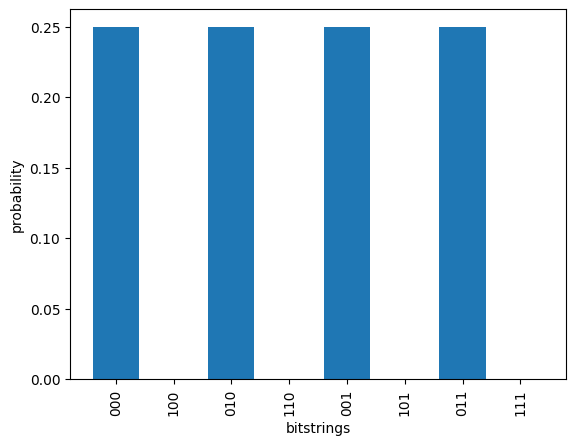

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

task = device.run(qft_circ, shots=0)
result = task.result()
probs_values = result.values[1]

plt.bar(swapped_bitstring_keys, probs_values[reindex])
plt.xlabel("bitstrings")
plt.xticks(range(2**num_qubits), swapped_bitstring_keys, rotation="vertical")
plt.ylabel("probability");

# Summary

This notebook introduced the native gate set on IonQ consisting of GPI, GPi2, and arbitrary angle MS gates. It showed how common single-qubit gates can be decomposed into this gate set by using the Euler decomposition. Additionally, the decomposition methods were implemented in a subclass of the Braket `Circuit` class help with writing native circuits. 

For two-qubit gates, the notebook provided examples of mapping a CNot or a controlled-root of a Pauli gate into MS gates plus single-qubit rotations. This enabled the quantum Fourier transform to be implemented using the IonQ native gate set.  

By leveraging the capabilities of the native gate set and the provided decomposition methods, users can effectively utilize the IonQ platform for more advanced quantum algorithms. 